<a href="https://colab.research.google.com/github/AlexsendraSonali/DataScience/blob/main/Heart_Disease_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/150
3/3 - 2s - loss: 0.8728 - accuracy: 0.4969 - val_loss: 0.6716 - val_accuracy: 0.6038 - 2s/epoch - 555ms/step
Epoch 2/150
3/3 - 0s - loss: 0.7227 - accuracy: 0.5912 - val_loss: 0.6497 - val_accuracy: 0.6604 - 45ms/epoch - 15ms/step
Epoch 3/150
3/3 - 0s - loss: 0.8092 - accuracy: 0.5723 - val_loss: 0.6287 - val_accuracy: 0.6981 - 59ms/epoch - 20ms/step
Epoch 4/150
3/3 - 0s - loss: 0.7003 - accuracy: 0.6101 - val_loss: 0.6093 - val_accuracy: 0.6981 - 43ms/epoch - 14ms/step
Epoch 5/150
3/3 - 0s - loss: 0.6262 - accuracy: 0.6289 - val_loss: 0.5917 - val_accuracy: 0.7547 - 58ms/epoch - 19ms/step
Epoch 6/150
3/3 - 0s - loss: 0.6382 - accuracy: 0.6730 - val_loss: 0.5745 - val_accuracy: 0.7925 - 42ms/epoch - 14ms/step
Epoch 7/150
3/3 - 0s - loss: 0.6351 - accuracy: 0.7044 - val_loss: 0.5582 - val_accuracy: 0.7925 - 41ms/epoch - 14ms/step
Epoch 8/150
3/3 - 0s - loss: 0.5727 - accuracy: 0.7044 - val_loss: 0.5436 - val_accuracy: 0.7925 - 51ms/epoch - 17ms/step
Epoch 9/150
3/3 - 0s - lo

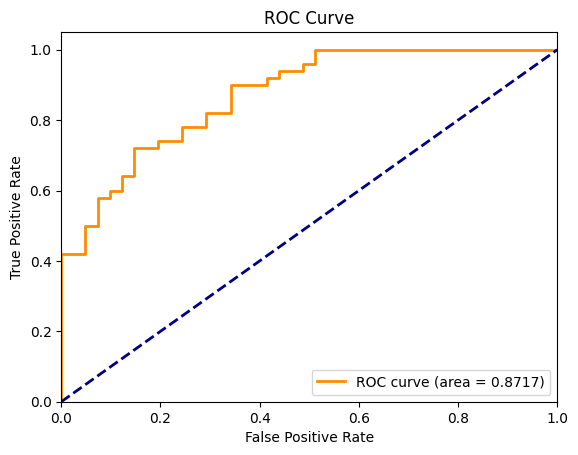

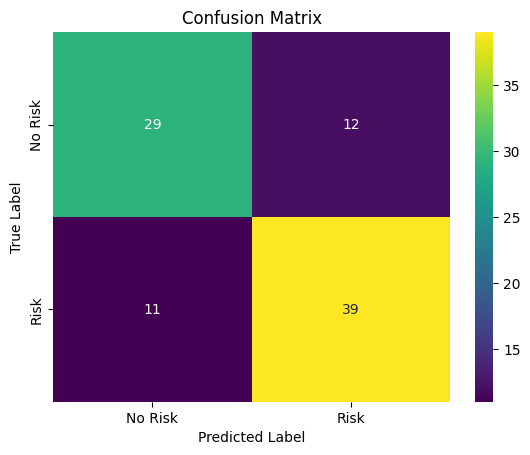

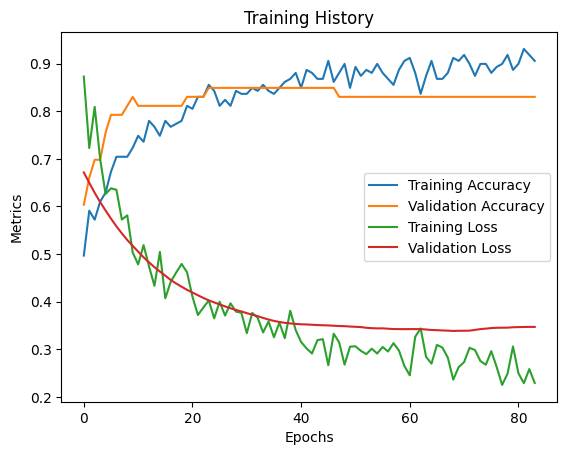

F1 Score: 0.7723


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8m0f14np/hj6wxy_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8m0f14np/hflv7eti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59338', 'data', 'file=/tmp/tmp8m0f14np/hj6wxy_2.json', 'init=/tmp/tmp8m0f14np/hflv7eti.json', 'output', 'file=/tmp/tmp8m0f14np/prophet_model1hgv02yu/prophet_model-20240706172052.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:20:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


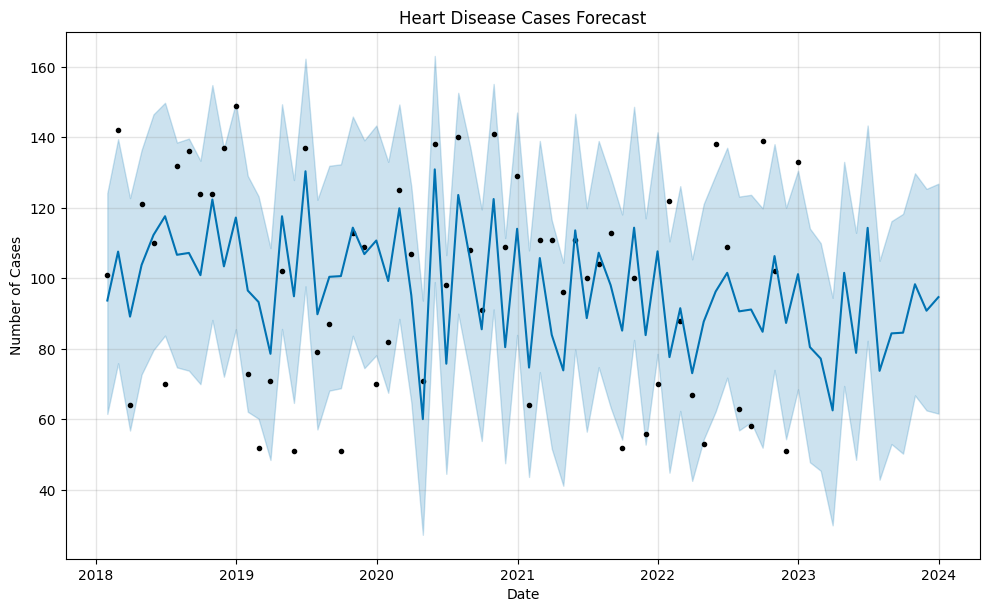

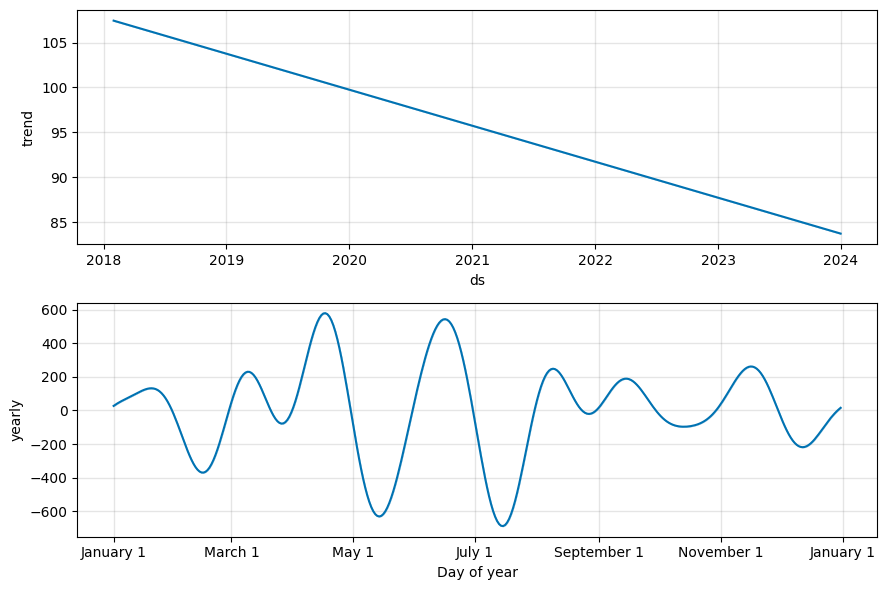

           ds        yhat  yhat_lower  yhat_upper
60 2023-01-31   80.503554   47.847542  114.123893
61 2023-02-28   77.250309   45.436470  109.979116
62 2023-03-31   62.569204   29.955058   94.483013
63 2023-04-30  101.572201   69.488239  133.026904
64 2023-05-31   78.871282   48.543373  112.910873
65 2023-06-30  114.327343   82.297234  143.343849
66 2023-07-31   73.775055   42.903839  104.982493
67 2023-08-31   84.397285   53.011550  116.220422
68 2023-09-30   84.597214   50.283953  118.289781
69 2023-10-31   98.336274   66.804914  129.809164
70 2023-11-30   90.830902   62.546410  125.379950
71 2023-12-31   94.683914   61.643437  126.851119


In [37]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet

df = pd.read_csv("heart.csv")


for column in df.columns:
    if df[column].dtype != object:
        median = df[column].median()
        df[column] = np.where((df[column] < (df[column].mean() - 3 * df[column].std())) |
                              (df[column] > (df[column].mean() + 3 * df[column].std())),
                              median, df[column])


X = df.drop(columns=['output'])
y = df['output']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


model = Sequential([
    Dense(128, input_dim=X_train.shape[1]),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(1),
    Activation('sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


history = model.fit(X_train, y_train, epochs=150, batch_size=64, validation_split=0.25,
                    callbacks=[early_stopping], verbose=2)


y_pred_prob = model.predict(X_test).flatten()


y_pred = (y_pred_prob > 0.5).astype(int)


print("Classification Report:\n", classification_report(y_test, y_pred))


roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC: {roc_auc:.4f}')

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['No Risk', 'Risk'],
            yticklabels=['No Risk', 'Risk'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training History')
plt.legend()
plt.show()


f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')


import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

date_range = pd.date_range(start='2018-01-01', periods=60, freq='M')


np.random.seed(42)
heart_disease_cases = np.random.randint(50, 150, size=(60,))


df_forecast = pd.DataFrame({'ds': date_range, 'y': heart_disease_cases})


prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(df_forecast)


future_dates = prophet_model.make_future_dataframe(periods=12, freq='M')


forecast = prophet_model.predict(future_dates)


prophet_model.plot(forecast)
plt.title('Heart Disease Cases Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.show()


prophet_model.plot_components(forecast)
plt.show()


print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))
